# LCEL = LangChain Expression Language 

- LCEL is a syntax to make it easier to work with different angents.
- It enables a "minimalist" code layer for building chains of LangChain components
- Benefits:
    - Streaming support 
    - Async support
    - Optimized parallel execution
    - Retries and fallbacks (not always we get the response we want from LLMs, so it's important to have this support)
    - Access intermediate results
    - etc (check https://python.langchain.com/docs/expression_language/ for more)
- LCEL and the runnable protocol define:
    - 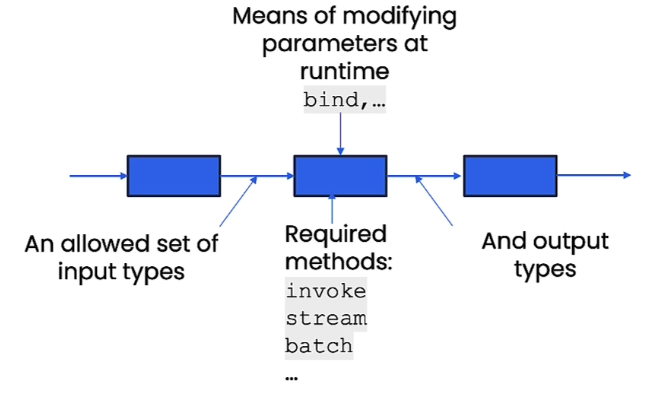

In [1]:
import os
import openai

In [2]:
openai_api_key = ""
open_ai_api_base = ""

openai.api_base = open_ai_api_base
openai.api_key = openai_api_key

In [4]:
os.environ['OPENAI_API_KEY'] = openai_api_key
os.environ['OPENAI_BASE_URL'] = open_ai_api_base

In [6]:
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI


In [7]:
from langchain_core.output_parsers.string import StrOutputParser

# Introduction to Langchain:

## 1) Simple Chain

In [8]:
prompt = ChatPromptTemplate.from_template(
    "tell me a short joke about {topic}"
)

model = ChatOpenAI()
output_parser = StrOutputParser()

chain = prompt | model | output_parser

chain.invoke({"topic":"horses"})

/Users/Livia_Pimentel/miniconda3/envs/chatbot_customer_intent/lib/python3.8/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


'Why did the horse cross the road?\n\nTo get to the neigh-borhood!'

# More complex chain - Retrieval Augmented Generation Pipeline (RAG)

- OpenAIEmbeddings: class designed to generate vector representations (embeddings) of texts using OpenAI models
- DocArrayInMemorySearch: is a document index provided by Docarray that stores documents in memory. It is a great starting point for small datasets, where you may not want to launch a database server

In [11]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch



In [13]:
vectorstore = DocArrayInMemorySearch.from_texts(
    ["harrison worked at kensho", "bears like to eat honey"],
    embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

In [14]:
# Question - answering: 
retriever.get_relevant_documents("where did harrison work?")

[Document(page_content='harrison worked at kensho'),
 Document(page_content='bears like to eat honey')]

In [15]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [16]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'))])

In [17]:
from langchain.schema.runnable import RunnableMap

In [18]:
chain = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]),
    "question": lambda x: x["question"]
}) | prompt | model | output_parser

chain.invoke({"question": "where did harrison work?"})

'Harrison worked at Kensho.'

In [19]:
inputs = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]),
    "question": lambda x: x["question"]
})

In [20]:
inputs.invoke({"question": "where did harrison work?"})

{'context': [Document(page_content='harrison worked at kensho'),
  Document(page_content='bears like to eat honey')],
 'question': 'where did harrison work?'}

# We can BIND parameters to runnables

Below, we have the following steps:

1) Defining functions based on name, description and parameters
2) **Prompt**: Format input text in a specific way before it's processed by the AI mode
3) **Bind**: .bind  method binds the previously defined functions to the model, enabling the model to call these functions based on the conversation's context or the user's input.
4) **runnable** :  This variable represents a chain of components (in this case, prompt and model) that are linked together using the | operator. This chaining mechanism allows for the output of one component to be passed as input to the next component in the chain. The **runnable.invoke({"input": "what is the weather in sf"})** executes the chained components with a given input. This input simulates a user asking about the weather in San Francisco (assumed by "sf").

In [21]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    }
  ]

prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}")
    ]
)
model = ChatOpenAI(temperature=0).bind(functions=functions)

runnable = prompt | model

runnable.invoke({"input": "what is the weather in sf"})




AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'weather_search'}})

# Fallbacks
- We can add fallbacks to an entire sequence

In [23]:
from langchain.llms import OpenAI # Older models generally aren't quite as good. We'll use them to practice creating fallbacks
import json

In [30]:
simple_model = OpenAI(temperature = 0,max_tokens = 1000, 
                      model="gpt-3.5-turbo-instruct")
simple_chain = simple_model | json.loads

In [25]:
challenge = "write three poems in a json blob, where each poem is a json blob of a title, author, and first line"

In [27]:
challenge

'write three poems in a json blob, where each poem is a json blob of a title, author, and first line'

In [31]:
simple_chain.invoke(challenge)

JSONDecodeError: Extra data: line 9 column 1 (char 125)

In [32]:
model = ChatOpenAI(temperature=0)
chain = model | StrOutputParser() | json.loads
chain.invoke(challenge)


{'poem1': {'title': 'The Rose',
  'author': 'Emily Dickinson',
  'firstLine': 'A rose is a rose is a rose'},
 'poem2': {'title': 'The Road Not Taken',
  'author': 'Robert Frost',
  'firstLine': 'Two roads diverged in a yellow wood'},
 'poem3': {'title': 'Hope is the Thing with Feathers',
  'author': 'Emily Dickinson',
  'firstLine': 'Hope is the thing with feathers'}}

In [ ]:
final_chain = simple_chain.with_fallbacks([chain])